# DAQ - Exercise 05
Author: Sebastian Pritz

Time required: 3h

## Solution Idea
In order to tackle the presented problem of binning data using the equal width, equal frequency and lloyd method, rather than implementing them by hand, I decided to research into existing tools, and stumbled over sklearn's KBinsDiscretizer class, which offers these three methods. Equal width method is called "uniform", equal frequency is called "quantile" and lloyd's method is simply the most common implementation of kmeans so that should suffice as well. Additionally, we asked Stefan Anlauf during his lessons whether it was okay to use "an ordinary KMeans" when it says "Lloyd" and he said yes. With that out of the way, to achieve the binning, the only thing left to do is write the necessary wrapper function that checks and maps the type parameter to the afforementioned techniques and also do some user error handling.

I really do not know why we were supposed to split the data into training and test datasets, since there's no way to compute any kind of error, since we aren't predicting values or anything of the like. It was however included, with the necessary shuffle.

Lastly, in order to visualize bins, histograms are the best option. Because I was interested in the distribution of the bins over the dataset (indices...) I also decided to create a scatter-plot demonstrating which indices belong to which bin for each used method.

## Implementation

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer
import plotly
import plotly.express as px
plotly.offline.init_notebook_mode(connected=True)

In [2]:
# Read data containing GPU specifications
data = pd.read_csv("gpu_specs_v6.csv")
data.describe()

,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader
count,2845.000000,2477.000000,2477.000000,2889.000000,2477.000000,2065.000000,2889.000000,2889.000000,824.000000,824.000000
mean,2010.691388,3.113803,274.874445,661.126687,868.578119,1032.937530,47.429214,18.750087,6.739078,2.622573
std,6.193125,7.175399,653.163896,374.481450,509.987396,1662.834618,73.014849,25.067896,8.091586,2.579388
min,1986.000000,0.000032,32.000000,10.000000,5.000000,8.000000,0.000000,0.000000,0.000000,0.000000
25%,2006.000000,0.256000,128.000000,400.000000,400.000000,144.000000,8.000000,4.000000,2.000000,0.000000
50%,2011.000000,1.024000,128.000000,600.000000,837.000000,384.000000,20.000000,8.000000,4.000000,2.000000
75%,2015.000000,3.000000,256.000000,875.000000,1250.000000,1280.000000,56.000000,24.000000,8.000000,4.000000
max,2023.000000,128.000000,8192.000000,2331.000000,2257.000000,17408.000000,880.000000,256.000000,48.000000,24.000000


In [3]:
# Split and shuffle the dataset
X_train, X_test = train_test_split(data, test_size=0.2, shuffle=True, random_state=1337)
X_train.sort_index(inplace=True)
X_test.sort_index(inplace=True)

In [4]:
def discretizationSelection(train: pd.DataFrame, test: pd.DataFrame, type: int, bins: int, names: list[str]) -> list[pd.DataFrame]:
    # Check the type and error handling
    if type == 0:
        strategy_ = "uniform"
    elif type == 1:
        strategy_ = "quantile"
    elif type == 2:
        strategy_ = "kmeans"
    else:
        print("Invalid type specified. Please pick one of the following: [0 (equal-width), 1 (equal-frequency), 2 (lloyd/kmeans)]")
        return train, test
    
    if bins < 1:
        print("Please enter a valid amount of bins (greater 0).")
        return train, test
    
    # First, make a deep copy to avoid altering the originals
    df_train = train.copy(deep=True)
    df_test = test.copy(deep=True)
    
    # Bin all specified columns in the dataframe and convert the columns to int (bin id)
    for column in names:
        est = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy=strategy_)
        est.fit(df_train[column].values.reshape(-1,1))
        df_train[column] = est.transform(df_train[column].values.reshape(-1,1))
        df_test[column] = est.transform(df_test[column].values.reshape(-1,1))
        df_train[column] = df_train[column].astype(np.uint32)
        df_test[column] = df_test[column].astype(np.uint32)
    return df_train, df_test

In [5]:
# Apply the binning to "gpuClock" column
train_width, test_width = discretizationSelection(X_train, X_test, 0, 5, ["gpuClock"])
train_freq, test_freq = discretizationSelection(X_train, X_test, 1, 5, ["gpuClock"])
train_lloyd, test_lloyd = discretizationSelection(X_train, X_test, 2, 5, ["gpuClock"])

# Show some sample data. As is evident below, Index 0 belongs to Bin 4, the others to bin 0.
train_width.head()


,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
0,NVIDIA,GeForce RTX 4050,2023.0,8.0,128.0,4,2250.0,3840.0,120,48,NaN,NaN,No,PCIe 4.0 x16,GDDR6,AD106
2,Intel,Arc A370M,2022.0,4.0,64.0,0,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
3,Intel,Arc A380,2022.0,4.0,64.0,0,1500.0,1024.0,64,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
4,Intel,Arc A550M,2022.0,8.0,128.0,0,1500.0,2048.0,128,64,NaN,NaN,No,PCIe 4.0 x16,GDDR6,DG2-512
5,Intel,Arc A730M,2022.0,12.0,192.0,0,1500.0,3072.0,192,96,NaN,NaN,No,PCIe 4.0 x16,GDDR6,DG2-512


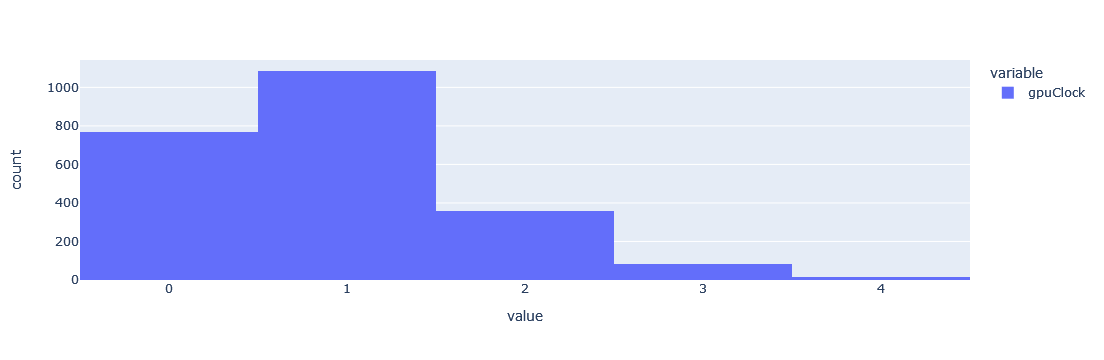

In [6]:
px.histogram(train_width["gpuClock"])

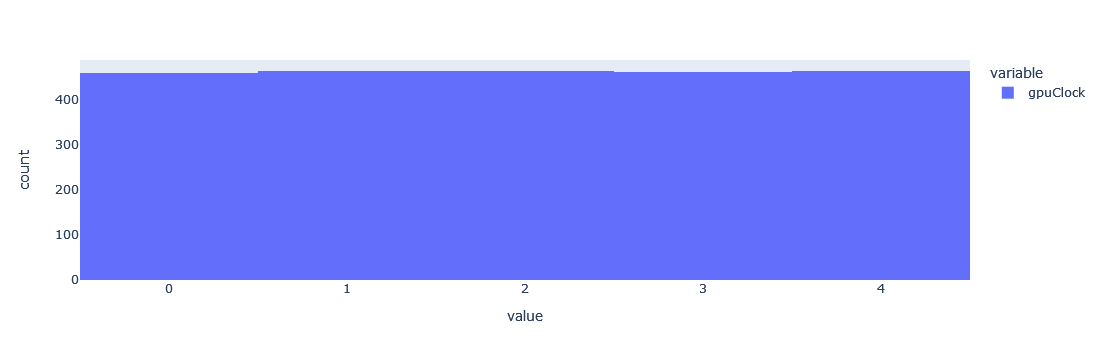

In [7]:
px.histogram(train_freq["gpuClock"])

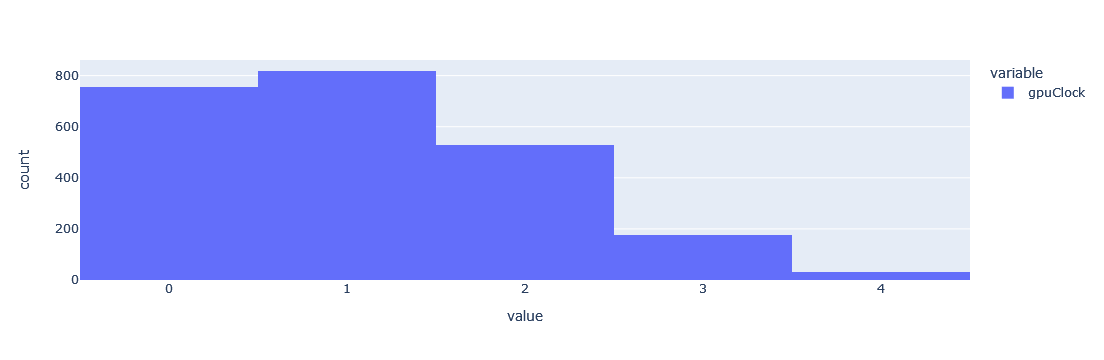

In [8]:
px.histogram(train_lloyd["gpuClock"])

In [9]:
# Just for the sake of completeness... It also works for the test dataset.
test_lloyd.head()

,manufacturer,productName,releaseYear,memSize,memBusWidth,gpuClock,memClock,unifiedShader,tmu,rop,pixelShader,vertexShader,igp,bus,memType,gpuChip
1,Intel,Arc A350M,2022.0,4.0,64.0,0,1500.0,768.0,48,24,NaN,NaN,No,PCIe 4.0 x8,GDDR6,DG2-128
6,Intel,Arc A770,2022.0,16.0,256.0,0,1500.0,4096.0,256,128,NaN,NaN,No,PCIe 4.0 x16,GDDR6,DG2-512
12,NVIDIA,GeForce RTX 3050 4 GB,2022.0,4.0,128.0,3,1750.0,2304.0,72,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,GA107
13,NVIDIA,GeForce RTX 3050 8 GB,2022.0,8.0,128.0,3,1750.0,2560.0,80,32,NaN,NaN,No,PCIe 4.0 x8,GDDR6,GA106
20,NVIDIA,GeForce RTX 3080 Ti Max-Q,2022.0,16.0,256.0,1,1500.0,7424.0,232,96,NaN,NaN,No,PCIe 4.0 x16,GDDR6,GA103S


In [10]:
# Create a long format dataframe featuring id (x-axis), binning method (y-axis) and the binning column (color)
train_width["method"] = pd.Series(["Width"] * train_width.shape[0], index=train_width.index)
train_width["id"] = train_width.index
train_freq["method"] = pd.Series(["Freq"] * train_freq.shape[0], index=train_freq.index)
train_freq["id"] = train_freq.index
train_lloyd["method"] = pd.Series(["Lloyd"] * train_lloyd.shape[0], index=train_lloyd.index)
train_lloyd["id"] = train_lloyd.index

combined = pd.concat([
    train_width.loc[:,["id", "gpuClock", "method"]],
    train_freq.loc[:,["id", "gpuClock", "method"]],
    train_lloyd.loc[:,["id", "gpuClock", "method"]]
], axis=0
)
combined.rename(columns={"gpuClock": "bin"}, inplace=True)
combined

,id,bin,method
0,0,4,Width
2,2,0,Width
3,3,0,Width
4,4,0,Width
5,5,0,Width
...,...,...,...
2882,2882,0,Lloyd
2883,2883,0,Lloyd
2884,2884,0,Lloyd
2886,2886,0,Lloyd


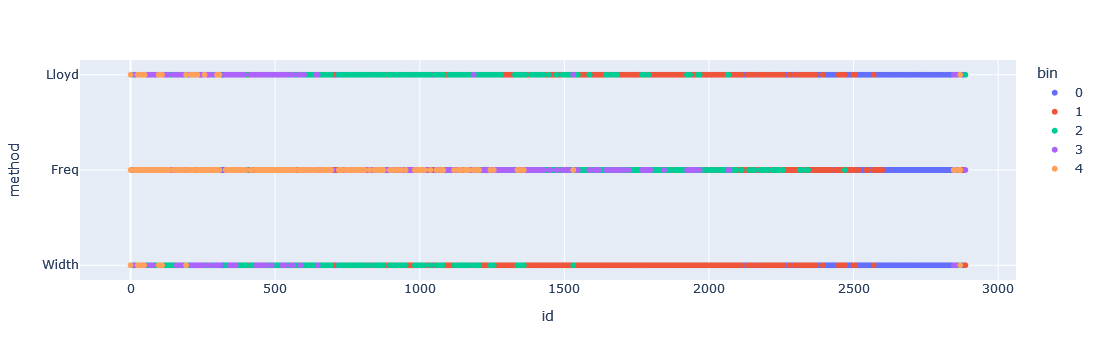

In [11]:
fig = px.scatter(combined, x="id", y="method", color="bin", category_orders={"bin": [0, 1, 2, 3, 4]})
fig.show()

## Test Cases

In [12]:
x, y = discretizationSelection(X_train, X_test, -1, 0, ["gpuClock"])

Invalid type specified. Please pick one of the following: [0 (equal-width), 1 (equal-frequency), 2 (lloyd/kmeans)]


In [13]:
x, y = discretizationSelection(X_train, X_test, 0, -1, ["gpuClock"])

Please enter a valid amount of bins (greater 0).


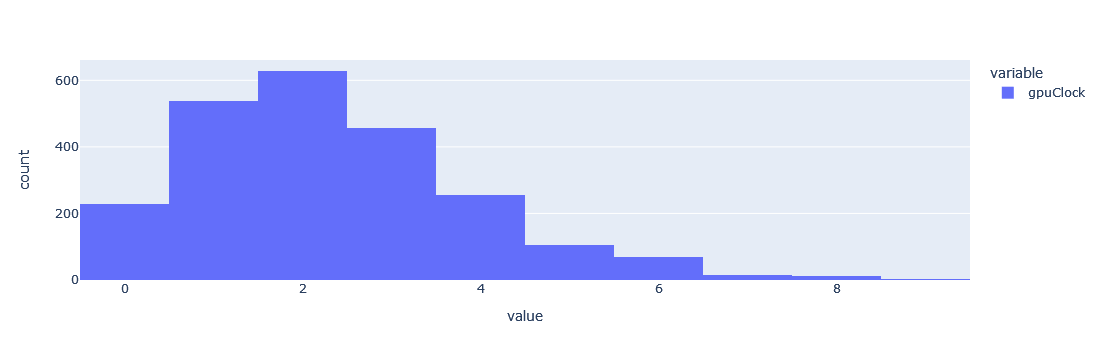

In [14]:
x, y = discretizationSelection(X_train, X_test, 0, 10, ["gpuClock"])
px.histogram(x["gpuClock"])